In [1]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql.window import Window

In [5]:
spark = SparkSession.builder.getOrCreate()

In [6]:
data = spark.read.csv("joined_cust_sales.csv", inferSchema=True, header=True, sep=",").cache()

25/01/07 09:17:58 WARN CacheManager: Asked to cache already cached data.


In [7]:
data = data.withColumn('new_purchase_date', to_date(unix_timestamp('purchase_date', 'yyyy/MM/dd').cast("timestamp"))).drop('purchase_date')

In [8]:
data.printSchema()

root
 |-- cust: integer (nullable = true)
 |-- address: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- status: string (nullable = true)
 |-- ocupation: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- product: string (nullable = true)
 |-- quantity: integer (nullable = true)
 |-- total_spending: integer (nullable = true)
 |-- new_purchase_date: date (nullable = true)



In [9]:
data = data.orderBy(["cust", "new_purchase_date"], ascending=True)

In [10]:
window = Window.partitionBy(data['cust']).orderBy(data['new_purchase_date'])
data = data.select('*', rank().over(window).alias('purchase_number'))
data.show()

+----+--------+------+------+----------+---+---------+--------+--------------+-----------------+---------------+
|cust| address|gender|status| ocupation|age|  product|quantity|total_spending|new_purchase_date|purchase_number|
+----+--------+------+------+----------+---+---------+--------+--------------+-----------------+---------------+
|   1|  Minato|     F|single|      chef| 25|    bento|       5|          2500|       2010-02-18|              1|
|   1|  Minato|     F|single|      chef| 25|    bento|       5|          2500|       2010-02-18|              1|
|   1|  Minato|     F|single|      chef| 25|    bento|       2|          1000|       2019-07-01|              3|
|   2|Setagaya|     M|single| architect| 40|   coffee|       1|           500|       2012-12-12|              1|
|   2|Setagaya|     M|single|consultant| 40|   snacks|       4|           800|       2014-09-26|              2|
|   2|Setagaya|     M|single|consultant| 40|   snacks|       5|          1000|       2015-09-04|

In [11]:
total_spending = data.groupBy('cust').sum('total_spending').select('cust', 'sum(total_spending)')
total_spending.show()

+----+-------------------+
|cust|sum(total_spending)|
+----+-------------------+
|  31|               2000|
|  65|               5000|
|  53|               1200|
|  34|               1800|
|  76|               1600|
|  27|              10000|
|  26|               4500|
|  44|               3500|
|  12|                600|
|  47|               3500|
|   1|               6000|
|  52|               2600|
|  13|               4700|
|  16|               2400|
|   3|               3900|
|  40|               4000|
|  57|               2000|
|  54|               8500|
|  48|               5600|
|  19|               4000|
+----+-------------------+
only showing top 20 rows



In [12]:
visit_window = Window.partitionBy('cust')
data = data.withColumn('total_visits', max('purchase_number').over(visit_window))


In [13]:
data = data.alias('data')
total_spending = total_spending.alias('total_spending')
data = total_spending.join(data, total_spending['cust'] == data['cust'], 'left').drop(total_spending['cust'])


In [14]:
spending_behavior = data.groupBy('cust').agg(
    count('purchase_number').alias('num_purchases'),
    sum('total_spending').alias('total_spent'),
    avg('total_spending').alias('avg_spent_per_purchase')
)


In [15]:
spending_behavior.show()
#Calculate total spending, average spending per purchase, and the number of purchases for each customer.

+----+-------------+-----------+----------------------+
|cust|num_purchases|total_spent|avg_spent_per_purchase|
+----+-------------+-----------+----------------------+
|  31|            2|       2000|                1000.0|
|  65|            4|       5000|                1250.0|
|  53|            2|       1200|                 600.0|
|  34|            2|       1800|                 900.0|
|  76|            1|       1600|                1600.0|
|  27|            6|      10000|    1666.6666666666667|
|  26|            2|       4500|                2250.0|
|  44|            2|       3500|                1750.0|
|  12|            2|        600|                 300.0|
|  47|            2|       3500|                1750.0|
|   1|            3|       6000|                2000.0|
|  52|            4|       2600|                 650.0|
|  13|            4|       4700|                1175.0|
|  16|            2|       2400|                1200.0|
|   3|            4|       3900|                

In [16]:
purchase_trends = data.groupBy('new_purchase_date').agg(
    countDistinct('cust').alias('unique_customers'),
    sum('total_spending').alias('total_sales')
)

In [17]:
purchase_trends.show()


+-----------------+----------------+-----------+
|new_purchase_date|unique_customers|total_sales|
+-----------------+----------------+-----------+
|       2014-09-26|               1|        800|
|       2011-07-07|               1|       2500|
|       2010-02-20|               1|        800|
|       2015-04-01|               1|        500|
|       2013-08-14|               1|       1500|
|       2012-01-09|               1|       2000|
|       2010-02-18|               1|       5000|
|       2012-08-05|               1|       1500|
|       2018-09-18|               1|       2000|
|       2014-07-23|               1|        800|
|       2015-08-24|               1|        500|
|       2015-01-20|               1|       2500|
|       2017-04-25|               1|       2000|
|       2011-06-13|               1|       1500|
|       2016-12-13|               1|       4000|
|       2019-09-08|               1|       2000|
|       2011-04-07|               1|       2000|
|       2017-03-19| 

In [18]:
sales_trends = data.groupBy('new_purchase_date').agg(
    sum('total_spending').alias('total_sales'),
    countDistinct('cust').alias('unique_customers')
)

sales_trends.orderBy('new_purchase_date').show()


+-----------------+-----------+----------------+
|new_purchase_date|total_sales|unique_customers|
+-----------------+-----------+----------------+
|       2010-01-03|       1500|               1|
|       2010-02-18|       5000|               1|
|       2010-02-20|        800|               1|
|       2010-02-23|       1500|               1|
|       2010-02-25|       1000|               1|
|       2010-02-28|       1000|               1|
|       2010-03-05|       1600|               1|
|       2010-03-10|       1000|               1|
|       2010-03-12|       1000|               1|
|       2010-03-15|       4500|               1|
|       2010-03-30|       1200|               1|
|       2010-05-10|       2500|               1|
|       2010-06-17|       2000|               1|
|       2010-07-16|        500|               1|
|       2010-08-04|        500|               1|
|       2010-08-09|       1000|               1|
|       2010-08-23|       1500|               1|
|       2010-08-28| 

In [19]:
sales_trends = sales_trends.withColumn(
    'avg_spending_per_customer',
    col('total_sales') / col('unique_customers')
)

sales_trends.orderBy('new_purchase_date').show()


25/01/07 09:18:03 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


+-----------------+-----------+----------------+-------------------------+
|new_purchase_date|total_sales|unique_customers|avg_spending_per_customer|
+-----------------+-----------+----------------+-------------------------+
|       2010-01-03|       1500|               1|                   1500.0|
|       2010-02-18|       5000|               1|                   5000.0|
|       2010-02-20|        800|               1|                    800.0|
|       2010-02-23|       1500|               1|                   1500.0|
|       2010-02-25|       1000|               1|                   1000.0|
|       2010-02-28|       1000|               1|                   1000.0|
|       2010-03-05|       1600|               1|                   1600.0|
|       2010-03-10|       1000|               1|                   1000.0|
|       2010-03-12|       1000|               1|                   1000.0|
|       2010-03-15|       4500|               1|                   4500.0|
|       2010-03-30|      

In [20]:
customer_spending = data.groupBy('cust').agg(
    sum('total_spending').alias('total_spent'),
    avg('total_spending').alias('avg_spent_per_purchase'),
    count('purchase_number').alias('num_purchases')
)

customer_spending.orderBy('total_spent', ascending=False).show()


+----+-----------+----------------------+-------------+
|cust|total_spent|avg_spent_per_purchase|num_purchases|
+----+-----------+----------------------+-------------+
|  29|      16500|                2750.0|            6|
|  56|      13500|                2250.0|            6|
|  38|      13300|                1900.0|            7|
|  71|      13000|                1625.0|            8|
|  64|      12100|    1344.4444444444443|            9|
|  61|      11500|    1916.6666666666667|            6|
|  45|      11000|    1222.2222222222222|            9|
|  27|      10000|    1666.6666666666667|            6|
|  23|      10000|                2000.0|            5|
|  62|       9000|                2250.0|            4|
|  54|       8500|                2125.0|            4|
|   4|       8000|                2000.0|            4|
|  39|       8000|    1333.3333333333333|            6|
|  30|       8000|                2000.0|            4|
|  55|       6600|                1100.0|       

In [21]:
top_customers = customer_spending.orderBy('total_spent', ascending=False).limit(10)
top_customers.show()


+----+-----------+----------------------+-------------+
|cust|total_spent|avg_spent_per_purchase|num_purchases|
+----+-----------+----------------------+-------------+
|  29|      16500|                2750.0|            6|
|  56|      13500|                2250.0|            6|
|  38|      13300|                1900.0|            7|
|  71|      13000|                1625.0|            8|
|  64|      12100|    1344.4444444444443|            9|
|  61|      11500|    1916.6666666666667|            6|
|  45|      11000|    1222.2222222222222|            9|
|  27|      10000|    1666.6666666666667|            6|
|  23|      10000|                2000.0|            5|
|  62|       9000|                2250.0|            4|
+----+-----------+----------------------+-------------+



In [22]:
total_revenue = data.agg(sum('total_spending')).collect()[0][0]
unique_customers = data.select(countDistinct('cust')).collect()[0][0]
total_transactions = data.select(count('purchase_number')).collect()[0][0]
avg_transaction_value = total_revenue / total_transactions

print(f"Total Revenue: {total_revenue}")
print(f"Unique Customers: {unique_customers}")
print(f"Total Transactions: {total_transactions}")
print(f"Average Transaction Value: {avg_transaction_value}")


Total Revenue: 295800
Unique Customers: 57
Total Transactions: 210
Average Transaction Value: 1408.5714285714287


In [23]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, sum as _sum, avg, max as _max, to_date, unix_timestamp
from pyspark.sql.window import Window

spark = SparkSession.builder.appName("LoyalCustomers").getOrCreate()

data = spark.read.csv("joined_cust_sales.csv", inferSchema=True, header=True, sep=",")

data = data.withColumn(
    'new_purchase_date', to_date(unix_timestamp('purchase_date', 'yyyy/MM/dd').cast("timestamp"))
).drop('purchase_date')

data = data.orderBy(["cust", "new_purchase_date"], ascending=True)

window = Window.partitionBy('cust').orderBy('new_purchase_date')
data = data.select('*', count('new_purchase_date').over(window).alias('purchase_number'))

loyalty_metrics = data.groupBy('cust').agg(
    _sum('total_spending').alias('total_spent'),
    count('product').alias('num_purchases'),
    avg('total_spending').alias('avg_spent_per_purchase'),
    _max('new_purchase_date').alias('last_purchase_date')
)

loyalty_metrics = loyalty_metrics.withColumnRenamed('cust', 'loyal_customer')

loyal_customers = loyalty_metrics.filter(
    (col('num_purchases') >= 5) & (col('total_spent') >= 1000)
)

loyal_customers.show()

loyal_customers.write.csv("loyal_customer.csv", header=True, mode="overwrite")

spark.stop()

25/01/07 09:18:05 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


+--------------+-----------+-------------+----------------------+------------------+
|loyal_customer|total_spent|num_purchases|avg_spent_per_purchase|last_purchase_date|
+--------------+-----------+-------------+----------------------+------------------+
|            27|      10000|            6|    1666.6666666666667|        2020-08-07|
|            64|      12100|            9|    1344.4444444444443|        2020-05-27|
|            61|      11500|            6|    1916.6666666666667|        2019-12-04|
|            55|       6600|            6|                1100.0|        2019-07-04|
|            23|      10000|            5|                2000.0|        2020-08-16|
|            39|       8000|            6|    1333.3333333333333|        2020-06-30|
|             7|       6100|            6|    1016.6666666666666|        2020-07-06|
|            50|       6400|            6|    1066.6666666666667|        2019-03-04|
|            45|      11000|            9|    1222.2222222222222|

In [24]:
pip install matplotlib pandas


DEPRECATION: Loading egg at /opt/anaconda3/lib/python3.11/site-packages/jupyter-1.0.0-py3.11.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /opt/anaconda3/lib/python3.11/site-packages/jsonpointer-3.0.0-py3.11.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
Note: you may need to restart the kernel to use updated packages.


In [25]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = "rare.csv"
data = pd.read_csv(file_path)


In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
file_path = "loyal_customer1.csv"
  # Replace with the correct path
data = pd.read_csv(file_path)

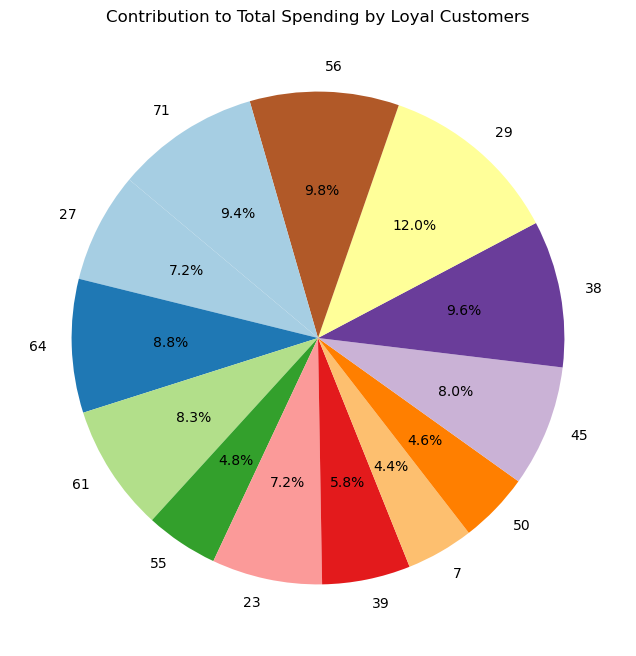

In [27]:
plt.figure(figsize=(8, 8))
plt.pie(
    data['total_spent'], 
    labels=data['loyal_customer'], 
    autopct='%1.1f%%', 
    startangle=140, 
    colors=plt.cm.Paired.colors
)
plt.title('Contribution to Total Spending by Loyal Customers')
plt.show()


In [28]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, sum as _sum, avg, max as _max, min as _min, to_date, unix_timestamp
from pyspark.sql.window import Window

spark = SparkSession.builder.appName("LoyalCustomers").getOrCreate()

data = spark.read.csv("joined_cust_sales.csv", inferSchema=True, header=True, sep=",")

data = data.withColumn(
    'new_purchase_date', to_date(unix_timestamp('purchase_date', 'yyyy/MM/dd').cast("timestamp"))
).drop('purchase_date')

data = data.orderBy(["cust", "new_purchase_date"], ascending=True)

window = Window.partitionBy('cust').orderBy('new_purchase_date')
data = data.select('*', count('new_purchase_date').over(window).alias('purchase_number'))

frequency_metrics = data.groupBy('cust').agg(
    _sum('total_spending').alias('total_spent'),
    count('product').alias('num_purchases'),
    avg('total_spending').alias('avg_spent_per_purchase'),
    _max('new_purchase_date').alias('last_purchase_date'),
    _min('new_purchase_date').alias('first_purchase_date')
)

rare_customers = frequency_metrics.filter(
    (col('num_purchases') <= 2)
)

rare_customers.select(
    col('cust').alias('customers_rarely_visited'),
    col('avg_spent_per_purchase').alias('average_spent')
).show()

rare_customers.write.csv("rare_customers.csv", header=True, mode="overwrite")

spark.stop()

+------------------------+-------------+
|customers_rarely_visited|average_spent|
+------------------------+-------------+
|                      31|       1000.0|
|                      53|        600.0|
|                      34|        900.0|
|                      76|       1600.0|
|                      26|       2250.0|
|                      44|       1750.0|
|                      12|        300.0|
|                      47|       1750.0|
|                      16|       1200.0|
|                      40|       2000.0|
|                      17|        200.0|
|                      72|        700.0|
|                      10|       2000.0|
|                     102|        800.0|
|                      70|        800.0|
|                      32|        600.0|
|                      58|       2500.0|
|                      33|       1200.0|
|                      14|       1000.0|
|                      42|       1200.0|
+------------------------+-------------+
only showing top

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = "rare.csv"
data = pd.read_csv(file_path)


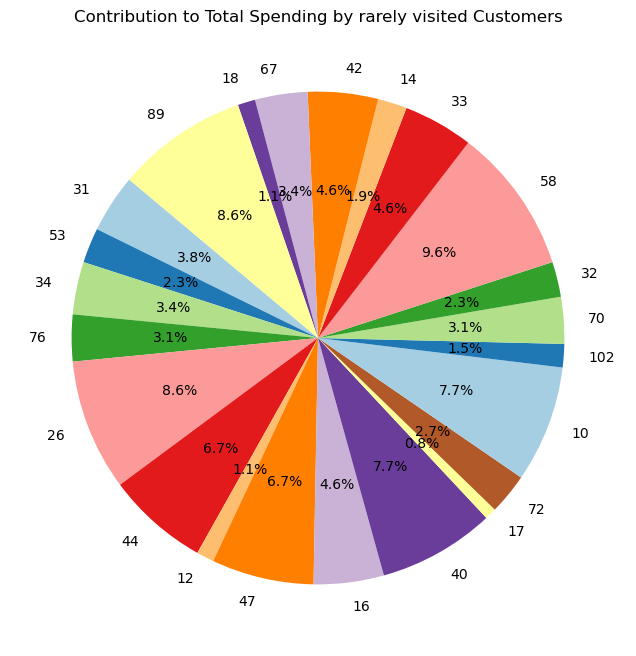

In [30]:
plt.figure(figsize=(8, 8))
plt.pie(
    data['total_spent'], 
    labels=data['cust'], 
    autopct='%1.1f%%', 
    startangle=140, 
    colors=plt.cm.Paired.colors
)
plt.title('Contribution to Total Spending by rarely visited Customers')
plt.show()


In [31]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import sum as _sum, count, mean, col
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

spark = SparkSession.builder.master("local").appName("CustomerAnalysis").getOrCreate()


In [32]:
data = spark.read.csv("joined_cust_sales.csv", header=True, inferSchema=True)
data.show()


+----+---------+------+-------+----------+---+-----------+--------+--------------+-------------+
|cust|  address|gender| status| ocupation|age|    product|quantity|total_spending|purchase_date|
+----+---------+------+-------+----------+---+-----------+--------+--------------+-------------+
|  37|      Ota|     M|married|   student| 47|     coffee|       3|          1500|   2010/01/03|
|   1|   Minato|     F| single|      chef| 25|      bento|       5|          2500|   2010/02/18|
|  64|     Koto|     M|married|    dancer| 39|        tea|       3|           600|   2010/03/30|
|  45|   Sumida|     M| single| architect| 55|      bento|       5|          2500|   2010/05/10|
|  54|   Sumida|     F| single|    lawyer| 53|    shampoo|       2|          2000|   2010/06/17|
|  55| Shinjuku|     M| single|consultant| 39|        egg|       1|           500|   2010/07/16|
|  23|   Bunkyo|     F|married|   teacher| 41|conditioner|       1|           500|   2010/08/04|
|  38| Setagaya|     M| single

In [33]:
customer_spend = data.groupBy("Cust").agg(_sum("total_spending").alias("TotalSpend"))

customer_frequency = data.groupBy("Cust").agg(count("cust").alias("Frequency"))

customer_data = customer_spend.join(customer_frequency, "Cust")
customer_data.show()


+----+----------+---------+
|Cust|TotalSpend|Frequency|
+----+----------+---------+
|  31|      2000|        2|
|  65|      5000|        4|
|  53|      1200|        2|
|  34|      1800|        2|
|  76|      1600|        1|
|  27|     10000|        6|
|  26|      4500|        2|
|  44|      3500|        2|
|  12|       600|        2|
|  47|      3500|        2|
|   1|      6000|        3|
|  52|      2600|        4|
|  13|      4700|        4|
|  16|      2400|        2|
|   3|      3900|        4|
|  40|      4000|        2|
|  57|      2000|        3|
|  54|      8500|        4|
|  48|      5600|        4|
|  19|      4000|        4|
+----+----------+---------+
only showing top 20 rows



In [34]:
assembler = VectorAssembler(inputCols=["TotalSpend", "Frequency"], outputCol="features")
customer_data = assembler.transform(customer_data)

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)
customer_data = scaler.fit(customer_data).transform(customer_data)


In [35]:
if "Cluster" in customer_data.columns:
    customer_data = customer_data.drop("Cluster")

kmeans = KMeans(featuresCol="scaledFeatures", k=3, predictionCol="Cluster")
model = kmeans.fit(customer_data)

customer_data = model.transform(customer_data)

from pyspark.sql.functions import mean
cluster_summary = customer_data.groupBy("Cluster").agg(
    mean("TotalSpend").alias("AvgSpend"),
    mean("Frequency").alias("AvgFrequency")
)
cluster_summary.show()



25/01/07 09:18:11 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/01/07 09:18:11 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


+-------+------------------+-----------------+
|Cluster|          AvgSpend|     AvgFrequency|
+-------+------------------+-----------------+
|      1|2258.3333333333335|            1.875|
|      2| 5445.833333333333|4.291666666666667|
|      0|12322.222222222223|6.888888888888889|
+-------+------------------+-----------------+



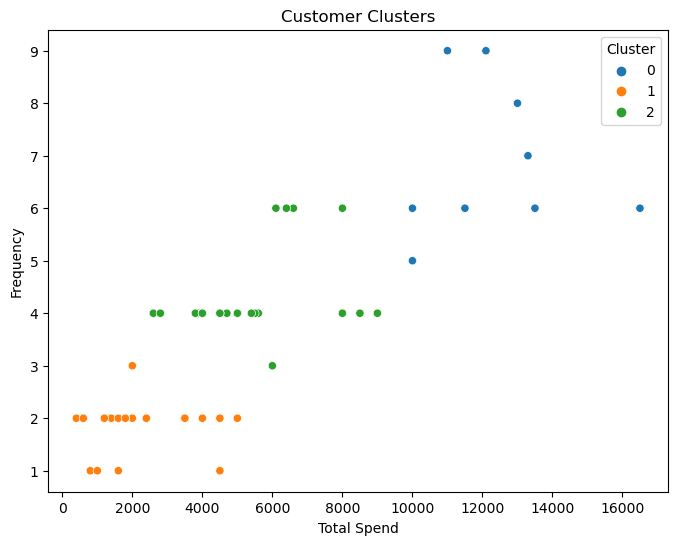

 Customer Segments:
   - Cluster 0: Rare Customers (Low Spend, Low Frequency)
   - Cluster 1: Loyal Customers (Moderate Spend, Moderate Frequency)
   - Cluster 2: Premium Customers (High Spend, High Frequency)


In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

customer_cluster_df = customer_data.select("TotalSpend", "Frequency", "Cluster").toPandas()

plt.figure(figsize=(8, 6))
sns.scatterplot(data=customer_cluster_df, x="TotalSpend", y="Frequency", hue="Cluster", palette="tab10")
plt.title("Customer Clusters")
plt.xlabel("Total Spend")
plt.ylabel("Frequency")
plt.show()


print(" Customer Segments:")
print("   - Cluster 0: Rare Customers (Low Spend, Low Frequency)")
print("   - Cluster 1: Loyal Customers (Moderate Spend, Moderate Frequency)")
print("   - Cluster 2: Premium Customers (High Spend, High Frequency)")